In [66]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import(
    KFold,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
    GridSearchCV
)


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import(
    train_test_split,
    cross_val_score,
)

from sklearn.linear_model import(
    LassoCV,
    ElasticNetCV,
    LinearRegression
)

from sklearn.feature_selection import(
    VarianceThreshold,
    chi2,
    SelectKBest,
)

from sklearn.ensemble import(
    RandomForestRegressor,
    GradientBoostingRegressor
)

from sklearn.metrics import(
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    explained_variance_score
)

from scipy.stats import skew

import pickle
import xgboost


#   Inter-Notebook Loader 
###  This code will load other notebooks in the same directory

In [3]:
def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        print("No path")
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path

class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % self.path)

        # load the notebook object
        with io.open(self.path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

In [287]:
feature_transform_path = os.getcwd() + "/feature_transform.ipynb"
nb = NotebookLoader(path=feature_transform_path)

In [288]:
feature_transform = nb.load_module(feature_transform_path)

importing Jupyter notebook from /Users/deangoldman/class/nycdsa/Housing/feature_transform.ipynb


/Users/deangoldman/class/nycdsa/Housing/feature_transform.ipynb:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  "metadata": {
/Users/deangoldman/class/nycdsa/Housing/feature_transform.ipynb:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  "collapsed": true
/Users/deangoldman/class/nycdsa/Housing/feature_transform.ipynb:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas

In [498]:
# import dataframe from feature_transform nb
df = feature_transform.train_numeric

# Categorical dataframe to binary encoding using category_encoders library

In [331]:
import category_encoders as ce
def to_binary(df):
    encoder = ce.binary.BinaryEncoder(cols=list(df.select_dtypes(['category']).columns))
    encoder.fit(df)

    df_binary = encoder.transform(df)
    df_binary.set_index("Id", inplace=True)
    df_binary.fillna(0, inplace=True)
    return df_binary
house = to_binary(house)

In [3]:
# Basic dummy variable dataframe

train = pd.read_csv("train.csv")
# train['GarageYrBlt'].fillna(train['YearBuilt'], inplace=True)
# train["PoolQC"].fillna("None", inplace=True)
# train["MiscFeature"].fillna("None", inplace=True)
# train["Alley"].fillna("None", inplace=True)
# train["MasVnrArea"].fillna(0, inplace=True)
# train["Fence"].fillna("None", inplace=True)
# train["FireplaceQu"].fillna("None", inplace=True)
# train["TotalBsmtSF"] = train["BsmtFinSF1"] + train["BsmtFinSF2"] + train["BsmtUnfSF"]
# train["TotalSF"] = train["TotalBsmtSF"] + train["1stFlrSF"] + train["2ndFlrSF"]
# train.drop(["TotalBsmtSF","1stFlrSF","2ndFlrSF"], axis=1, inplace=True)
# train['Electrical'] = train['Electrical'].fillna(train['Electrical'].mode()[0])
# train['KitchenQual'] = train['KitchenQual'].fillna(train['KitchenQual'].mode()[0])
# train['Exterior1st'] = train['Exterior1st'].fillna(train['Exterior1st'].mode()[0])
# train['Exterior2nd'] = train['Exterior2nd'].fillna(train['Exterior2nd'].mode()[0])
# train['SaleType'] = train['SaleType'].fillna(train['SaleType'].mode()[0])

# train["LotFrontage"] = train.groupby("Neighborhood")["LotFrontage"].transform(
#     lambda x: x.fillna(x.median()))
# for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
#     train[col] = train[col].fillna('None') 
# for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
#     train[col] = train[col].fillna(0)
# for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
#     train[col] = train[col].fillna('None')
# \
    
    
# train["Functional"] = train["Functional"].fillna("Typ")
train.drop(['Utilities'], axis=1, inplace=True)

# train_dummies = train_dummies.drop(524, axis=0)

def categorize(df):
    df['MSSubClass'] = df['MSSubClass'].astype("str")
    df['OverallCond'] = df['OverallCond'].astype("str")
    df['YrSold'] = df['YrSold'].astype("str")
    df['MoSold'] = df['MoSold'].astype("str")

    return df

train = categorize(train)
numeric_feats = train.dtypes[train.dtypes != "object"].index

# Applying logarithmic transform to skewed features
# This code was pulled from Alexandru Papiu:
# https://www.kaggle.com/apapiu/regularized-linear-models

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
train[skewed_feats] = np.log1p(train[skewed_feats])

# Getting dummy variables
train_dummies = pd.get_dummies(train, drop_first=True)
train_dummies = train_dummies.drop(train_dummies[(train_dummies['GrLivArea']>4000) & (train_dummies['SalePrice']<300000)].index)
train_dummies = train_dummies.fillna(train_dummies.mean())

In [173]:
# ### Unskew 

# def unskew(df):
#     numeric_feats = df.select_dtypes(include=["float64","int64"]).columns
#     # Applying logarithmic transform to skewed features
#     # This code was pulled from Alexandru Papiu:
#     # https://www.kaggle.com/apapiu/regularized-linear-models

#     skewed_feats = df[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
#     skewed_feats = skewed_feats[skewed_feats > 0.75]
#     skewed_feats = skewed_feats.index
#     df[skewed_feats] = np.log1p(df[skewed_feats])
#     return df

In [174]:
### Correlation Plots

def corrgraphs(df):
    neg = df.corr()[df.corr() < -0.9]
    neg = neg.dropna(how="all", axis=1)
    neg = neg.dropna(how="all", axis=0)
    pos = df.corr()[df.corr() > 0.9]
    pos = pos[pos < 1.0]
    pos = pos.dropna(how="all", axis=1)
    pos = pos.dropna(how="all", axis=0)
    return (neg, pos)
neg, pos = corrgraphs(train_dummies)

/Users/deangoldman/Library/Python/3.6/lib/python/site-packages/matplotlib/artist.py:879: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  return func(v)


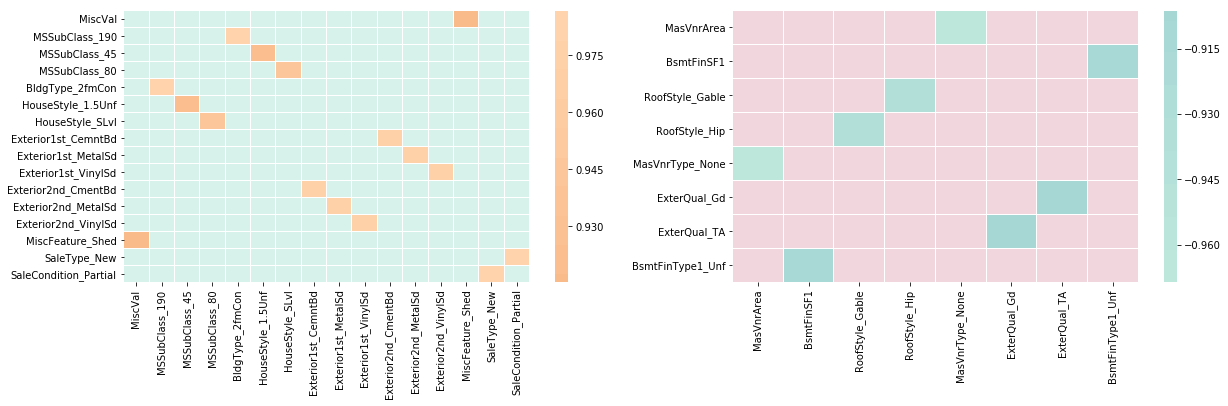

In [175]:
def plot_corrgraphs(neg, pos):
    fig, axs = plt.subplots(ncols=2, figsize=(20,5))
    pos_heatmap = sns.heatmap(pos, center=0, linewidths=0.01, ax=axs[0])
    pos_heatmap.set(axis_bgcolor="#D6F2EB")
    neg_heatmap = sns.heatmap(neg, center=0, linewidths=0.01, ax=axs[1])
    neg_heatmap.set(axis_bgcolor="#F2D6DD")
    return
plot_corrgraphs(neg, pos)

In [176]:
# # Example plot
# regplot = sns.regplot(x = 'KitchenQual', y = 'SalePrice', data = df, color = '#FFB733')
# regplot.set(axis_bgcolor="#A2BFF4")

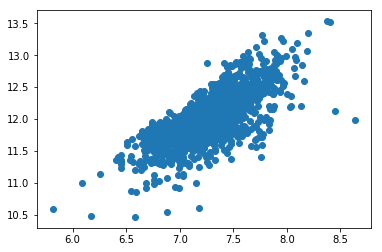

In [4]:

plt.scatter(train_dummies["GrLivArea"], train_dummies["SalePrice"])

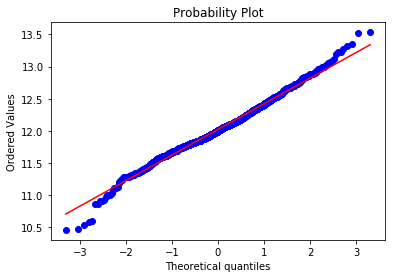

In [5]:
fig = plt.figure()
res = stats.probplot(train_dummies['SalePrice'], plot=plt)
plt.show()

In [160]:
# Variance Inflation Factor Filter
from statsmodels.stats.outliers_influence import variance_inflation_factor    
def vif_filter(X, thresh=100):
    cols = X.columns
    variables = np.arange(X.shape[1])
    dropped=True
    while dropped:
        dropped=False
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]
        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
#             print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables = np.delete(variables, maxloc)
            dropped=True

#     print('Remaining variables:')
#     print(X.columns[variables])
    return X[cols[variables]]

In [7]:
# Full dataframe into Train-test Split
def full_set_split(df):
    X = df.drop(["SalePrice","Id"], axis=1)
#     X = vif_filter(X, thresh=5)
    y = df["SalePrice"]
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    return (X_train, X_test, y_train, y_test)

In [162]:
msun_nb_path = os.getcwd() + "/msun_house_price_kaggle.ipynb"
nb = NotebookLoader(path=msun_nb_path)
msun_nb = nb.load_module(msun_nb_path)
# house = msun_nb.train
house = msun_nb.House('train.csv', 'test.csv', 'data_description.txt').train_data
# house = ordinal_to_numeric(house.train_data)
house[house.select_dtypes(['object']).columns] = house.select_dtypes(['object']).apply(lambda x: x.astype('category'))
house["MSSubClass"] = house["MSSubClass"].astype(str)
house_dummies = pd.get_dummies(house)
house_dummies['GarageYrBlt'].fillna(house_dummies['YearBuilt'], inplace=True)
house_dummies = house_dummies.fillna(0)

NameError: name 'NotebookLoader' is not defined

## Switch dataframes here

In [8]:

# df = unskew(train_dummies)
X_train, X_test, y_train, y_test = full_set_split(train_dummies)

# Modeling

In [70]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [71]:
lm.score(X_test, y_test)

0.9003639175692689

In [189]:
# sns.regplot(train['TotalBsmtSF'], y=df["BsmtUnfSF"])

In [11]:
# Calculate RMSE
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [12]:
# Lasso CV

model_lasso = LassoCV(normalize=True, cv=6).fit(X_train, y_train)
print(rmse_cv(model_lasso).mean())
model_lasso.score(X_test, y_test)

0.1440415923275416


0.9220993684859465

### Lasso CV Scores
The dataframe from msun_nb with ordinal imputation, skew correction, and binary encoding scores .88  
The train.csv -> dummies scores .89  
The dataframe (df) from feature_transform.ipynb scores .90

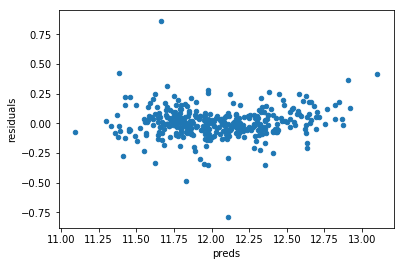

In [192]:
preds = pd.DataFrame({"preds":model_lasso.predict(X_test), "true":y_test})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

In [21]:
# preds.sort_values(by="residuals", ascending=True)

In [40]:
# Elastic Net CV

elastic_net = ElasticNetCV(alphas=[.001])
elastic_net.fit(X_train, y_train)
train_test(elastic_net, X_train, X_test, y_train, y_test)

ElasticNetCV(alphas=[0.001], copy_X=True, cv=None, eps=0.001,
       fit_intercept=True, l1_ratio=0.5, max_iter=1000, n_alphas=100,
       n_jobs=1, normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)
Train
-------------------------
R2: 0.9098915305029991
RMSE: 0.11427074236739598
Test
-------------------------
R2: 0.9181518105854896
RMSE: 0.10672614329376873


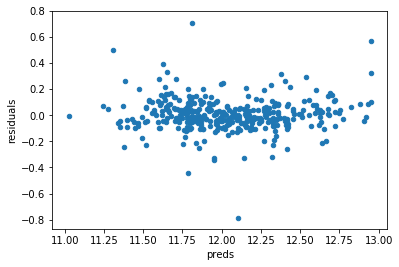

In [195]:
preds = pd.DataFrame({"preds":elastic_net.predict(X_test), "true":y_test})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

In [69]:
# rf = RandomForestRegressor()
# parameters = {"max_depth": [9,10,11,12],
#               "min_samples_split" :[2,3,4,5,6],
#               "n_estimators" : [100,500],
#               "max_features": (4,5,6)}

# grid_search = GridSearchCV(rf, parameters, n_jobs=3, cv=5)
# grid_search.fit(X_train,y_train)

In [67]:
from sklearn.externals import joblib
grid_search_rf = joblib.dump(grid_search, "grid_search_rf_dummies.pkl")

In [68]:
grid_search.score(X_test, y_test)

0.8313820647583924

In [124]:
xgb_model = xgboost.XGBRegressor()

xgb_parameters = {"colsample_bytree":[0.4,0.5], "gamma":[0.04], 
                             "learning_rate":[0.05], "max_depth":[3,4,5], 
                             "min_child_weight":[1.7817], "n_estimators":[1000],
                             "reg_alpha":[0.4640], "reg_lambda":[0.8571]}
xgb = xgboost.XGBRegressor()
grid_search_xgb = GridSearchCV(xgb_model, xgb_parameters,n_jobs=3, cv=5,verbose=2, refit=True)
grid_search_xgb.fit(X_train, y_train)
grid_search_xgb_save = joblib.dump(grid_search_xgb, "grid_search_xgb_dummies.pkl")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] colsample_bytree=0.4, gamma=0.04, learning_rate=0.05, max_depth=3, min_child_weight=1.7817, n_estimators=1000, reg_alpha=0.464, reg_lambda=0.8571 
[CV] colsample_bytree=0.4, gamma=0.04, learning_rate=0.05, max_depth=3, min_child_weight=1.7817, n_estimators=1000, reg_alpha=0.464, reg_lambda=0.8571 
[CV] colsample_bytree=0.4, gamma=0.04, learning_rate=0.05, max_depth=3, min_child_weight=1.7817, n_estimators=1000, reg_alpha=0.464, reg_lambda=0.8571 
[CV]  colsample_bytree=0.4, gamma=0.04, learning_rate=0.05, max_depth=3, min_child_weight=1.7817, n_estimators=1000, reg_alpha=0.464, reg_lambda=0.8571, total=   6.5s
[CV] colsample_bytree=0.4, gamma=0.04, learning_rate=0.05, max_depth=3, min_child_weight=1.7817, n_estimators=1000, reg_alpha=0.464, reg_lambda=0.8571 
[CV]  colsample_bytree=0.4, gamma=0.04, learning_rate=0.05, max_depth=3, min_child_weight=1.7817, n_estimators=1000, reg_alpha=0.464, reg_lambda=0.8571, total=   6.6

[CV] colsample_bytree=0.5, gamma=0.04, learning_rate=0.05, max_depth=5, min_child_weight=1.7817, n_estimators=1000, reg_alpha=0.464, reg_lambda=0.8571 
[CV]  colsample_bytree=0.5, gamma=0.04, learning_rate=0.05, max_depth=5, min_child_weight=1.7817, n_estimators=1000, reg_alpha=0.464, reg_lambda=0.8571, total=  14.0s
[CV] colsample_bytree=0.5, gamma=0.04, learning_rate=0.05, max_depth=5, min_child_weight=1.7817, n_estimators=1000, reg_alpha=0.464, reg_lambda=0.8571 
[CV]  colsample_bytree=0.5, gamma=0.04, learning_rate=0.05, max_depth=5, min_child_weight=1.7817, n_estimators=1000, reg_alpha=0.464, reg_lambda=0.8571, total=  14.0s
[CV] colsample_bytree=0.5, gamma=0.04, learning_rate=0.05, max_depth=5, min_child_weight=1.7817, n_estimators=1000, reg_alpha=0.464, reg_lambda=0.8571 
[CV]  colsample_bytree=0.5, gamma=0.04, learning_rate=0.05, max_depth=5, min_child_weight=1.7817, n_estimators=1000, reg_alpha=0.464, reg_lambda=0.8571, total=  13.8s
[CV]  colsample_bytree=0.5, gamma=0.04, lea

[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed:  1.8min finished


In [128]:
grid_search_xgb.score(X)

{'colsample_bytree': 0.4,
 'gamma': 0.04,
 'learning_rate': 0.05,
 'max_depth': 5,
 'min_child_weight': 1.7817,
 'n_estimators': 1000,
 'reg_alpha': 0.464,
 'reg_lambda': 0.8571}

In [ ]:
#Validation function
n_folds = 5

def cross_val(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

cross_val(model_xgb)

In [143]:
# Random Forest

rf = RandomForestRegressor(n_estimators=200, oob_score=True)
rf.fit(X_train, y_train)
print(rmse_cv(rf).mean())
rf.score(X_test, y_test)

0.1482858643591563


0.861338810109889

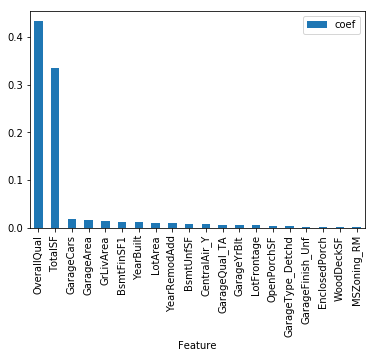

In [76]:
coefs = pd.DataFrame(X_train.columns, rf.feature_importances_).reset_index().rename(index=str, columns={"index":"coef",0:"Feature"})
ax = coefs.set_index("Feature").sort_values(by="coef",ascending=False)[:20].plot.bar()
coefs.to_pickle("dummy_rf_Serigne.pkl")

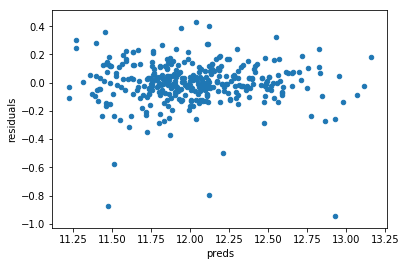

In [77]:
preds = pd.DataFrame({"preds":rf.predict(X_test), "true":y_test})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

In [39]:
# Gradient Boosting

gboost = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.085,
                                   max_depth=2, max_features=10,loss="huber")
gboost.fit(X_train, y_train)

# Prints R2 and RMSE scores
def get_score(pred, y):
    print('R2: {}'.format(r2_score(pred, y)))
    print('RMSE: {}'.format(np.sqrt(mean_squared_error(pred, y))))

# Shows scores for train and validation sets    
def train_test(estimator, x_trn, x_tst, y_trn, y_tst):
    pred_train = estimator.predict(x_trn)
    # Printing estimator
    print(estimator)
    print("Train")
    print("-"*25)
    # Printing train scores
    get_score(pred_train, y_trn)
    pred_test = estimator.predict(x_tst)
    # Printing test scores
    print("Test")
    print("-"*25)
    get_score(pred_test, y_tst)

train_test(gboost, X_train, X_test, y_train, y_test)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.085, loss='huber', max_depth=2,
             max_features=10, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)
Train
-------------------------
R2: 0.9578549030242851
RMSE: 0.07931967305269269
Test
-------------------------
R2: 0.9018964269964478
RMSE: 0.11206636793484553


In [17]:
model_xgb = xgboost.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [19]:
#Validation function
n_folds = 5

def cross_val(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

cross_val(model_xgb)

array([0.13541703, 0.13044538, 0.1509442 , 0.12699841, 0.13438123])

In [29]:
scores = cross_val_score(model_xgb, X_train, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.89 (+/- 0.03)


In [31]:
model_xgb.fit(X_train, y_train)
model_xgb.score(X_test, y_test)

0.9066910552026446

In [74]:
combined_pred = (
    lm.predict(X_test) +
    model_xgb.predict(X_test) +
    model_lasso.predict(X_test) +
    elastic_net.predict(X_test) +
    gboost.predict(X_test))/ 5
print('R2: {}'.format(r2_score(combined_pred, y_test)))

R2: 0.9205566524535064


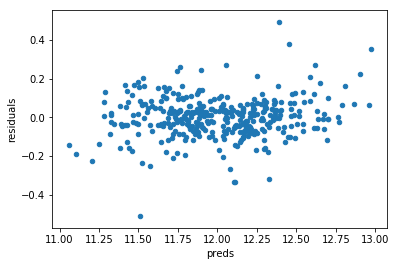

In [64]:
preds = pd.DataFrame({"preds":combined_pred, "true":y_test})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  if __name__ == '__main__':


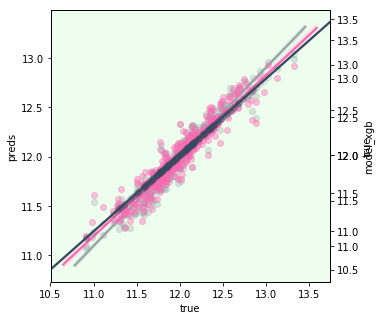

In [113]:
all_preds = pd.DataFrame({"preds": combined_pred,
                          "lm": lm.predict(X_test),
                          "model_lasso": model_lasso.predict(X_test),
                          "model_xgb": model_xgb.predict(X_test),
                          "elastic_net": elastic_net.predict(X_test),
                          "true":y_test
                         })
fig, ax = plt.subplots(figsize=(5,5))
ax.set_axis_bgcolor("#eefeee")
sns.regplot(x='true', y='preds', data=all_preds, ax=ax, color="#95a5a6", scatter_kws={'alpha':.3})
# ax2 = ax.twinx()
# sns.regplot(x='true', y='lm', data=all_preds, ax=ax2, color="r", scatter_kws={'alpha':0})
# ax3 = ax.twinx()
# sns.regplot(x='true', y='model_lasso', data=all_preds, ax=ax3, color="#2ecc71", scatter_kws={'alpha':0})
# ax4 = ax.twinx()
# sns.regplot(x='true', y='elastic_net', data=all_preds, ax=ax4, color="#3498db", scatter_kws={'alpha':0})

ax5 = ax.twinx()
sns.regplot(x='true', y='model_xgb', data=all_preds, ax=ax5, color="#FF69B4", scatter_kws={'alpha':.4})
ax6 = ax.twinx()
sns.regplot(x='true', y='true', data=all_preds, ax=ax6, color="#34495e", scatter_kws={'alpha': 0.1})

In [73]:
print(mean_absolute_error(y_test, combined_pred))
print(mean_absolute_error(y_test, elastic_net.predict(X_test)))
print(mean_absolute_error(y_test, model_lasso.predict(X_test)))
print(mean_absolute_error(y_test, model_xgb.predict(X_test)))
print(mean_absolute_error(y_test, lm.predict(X_test)))

0.07530413366151853
0.07828444201268202
0.07921988167186991
0.0854422582531566
0.08495947051515414


In [62]:
print(explained_variance_score(y_test, combined_pred))
print(explained_variance_score(y_test, elastic_net.predict(X_test)))
print(explained_variance_score(y_test, model_lasso.predict(X_test)))
print(explained_variance_score(y_test, model_xgb.predict(X_test)))

0.9283142307085968
0.9248232057787331
0.9221032348473697
0.9069201957865901


In [63]:
print(mean_squared_error(y_test, combined_pred))
print(mean_squared_error(y_test, elastic_net.predict(X_test)))
print(mean_squared_error(y_test, model_lasso.predict(X_test)))
print(mean_squared_error(y_test, model_xgb.predict(X_test)))

0.010853276675726952
0.011390469662362054
0.011788577840345375
0.014120293219261967


In [401]:
# PCA workflow not being used atm.

# pca = PCA()
# # scaled_data = scale(X_train.T)
# # pca.fit(scaled_data)    

# pca.fit(scale(X_train))
# pca_data = pca.transform(scale(X_train))

# per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
# labels = ["PC" + str(x) for x in range(1, len(per_var) + 1)]
# plt.bar(left=range(1,6), height=per_var[:5], tick_label=labels[:5])
# plt.show()

# pca_df = pd.DataFrame(pca_data)
# plt.scatter(pca_df[0], pca_df[1], pca_df[3], c=["red","blue","green"])

In [34]:
# le = LabelEncoder()
# le.fit(train["KitchenQual"])
# list(le.classes_)
# tdf = pd.DataFrame([le.transform(train["KitchenQual"]),
#                    train["KitchenQual"],
#                    train["SalePrice"]]).T
# tdf.rename(columns={0:"Encoded", 1:"Original", 2:"SalePrice"}, inplace=True)

In [9]:
# def ordinal_to_numeric(df):
#     for i in range(len(df.columns)-1):
#         is_cat = df.iloc[:,i].values.any() in ("Gd","Ex","TA","Fa","Po")
#         if is_cat == True:
#             df[df.columns[i]] = df[df.columns[i]].map({"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1})
#     return df